# Border Classifier Training

In [1]:
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import pandas as pd
import cv2 as cv
import os
import pickle

# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, process_batch=True, training=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    training_test_folder = 'training' if training else 'test'
    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\dataset_new\\{training_test_folder}\\{parking_id}\\{weather}')
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        try:
            detection_params.show_imshow=False
            processor.process_batch(10)
        except (NoSpacesException, NoImageException) as ex:
            print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                detection_params.show_imshow=True
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    plot = not training
    metrics_provider.show_confusion_matrix(plot)

    return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, at_blockSize_list, vacant_threshold_list, training=False):
    detection_params.weather = weather
    metrics_dict = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for at_blockSize in at_blockSize_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} at_blockSize={at_blockSize}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.at_blockSize = at_blockSize
            metrics = test_parking(parking_id, weather, detection_params, True, training)
            
            metrics_dict_diff[at_blockSize] = metrics

        metrics_dict[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict
    # PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)
        
# def setup_params(parking_id, weather, initial_params:DetectionParams=None):
   
#     provider_params = ParkingProviderLocalParams(
#         parking_id=parking_id, path=f'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\{parking_id}\\{weather}', k=200)

#     parking_provider = ParkingProviderLocal(provider_params)

#     # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

#     # processor = ParkingOccupancyProcessorLocal(
#     #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

#     try:
#         params = initial_params
#         while True:
#         # while (it > 0 and i < it) or it < 0:
#         #     i = i+1
#         #     print(f"Processing sample: {str(i)}")
#         #     processor.process()

#             parking = parking_provider.get_parking()
#             img = parking.image
#             spaces = parking.spaces

#             params = OccupancyDetectorDiff.setup_params_img(img, parking_id, weather, spaces, params)

#             cv.namedWindow("Press ESC to exit, other key to continue")
#             key = cv.waitKey(0)
#             if key == 27:
#                 cv.destroyAllWindows()
#                 break  
              
#             cv.destroyAllWindows()
   
#     except (NoSpacesException, NoImageException) as ex:
#         print(f"Finished processing: ", ex)
#     finally:
#         return params
    
def calculate_metrics(parking_id, weather_list, at_blockSize_list, vacant_threshold_list, params=DetectionParams(), training=True, show_metrics=True, save_fig_dst=None):
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:
        
        file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"
        if not os.path.exists(file_pickle):
            metrics_dict_vt = test_vacant_threshold(parking_id, weather, params, at_blockSize_list, vacant_threshold_list, training)
        else:
            with open(file_pickle, 'rb') as f:
                print(file_pickle)
                metrics_dict_vt = pickle.load(f)
                
        # Saving the objects:   
        if not os.path.exists(file_pickle):
            f= open(file_pickle, 'wb')
            pickle.dump(metrics_dict_vt, f)


        if show_metrics and save_fig_dst is not None :
            fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
            PerformanceMetricsProviderSklearn.show_tpr_fpr(transpose_dict(metrics_dict_vt),parking_id, weather, show_diff=True, save_fig_dst=fig_dst)
    
def transpose_dict(dictionary):
    transposed_dict = {}
    for vacant_threshold, inner_dict in dictionary.items():
        for block_size, metrics in inner_dict.items():
            if block_size not in transposed_dict:
                transposed_dict[block_size] = {}
            transposed_dict[block_size][vacant_threshold] = metrics
    return transposed_dict

## UFPR04

### UFPR04 Training

test/bordersDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle


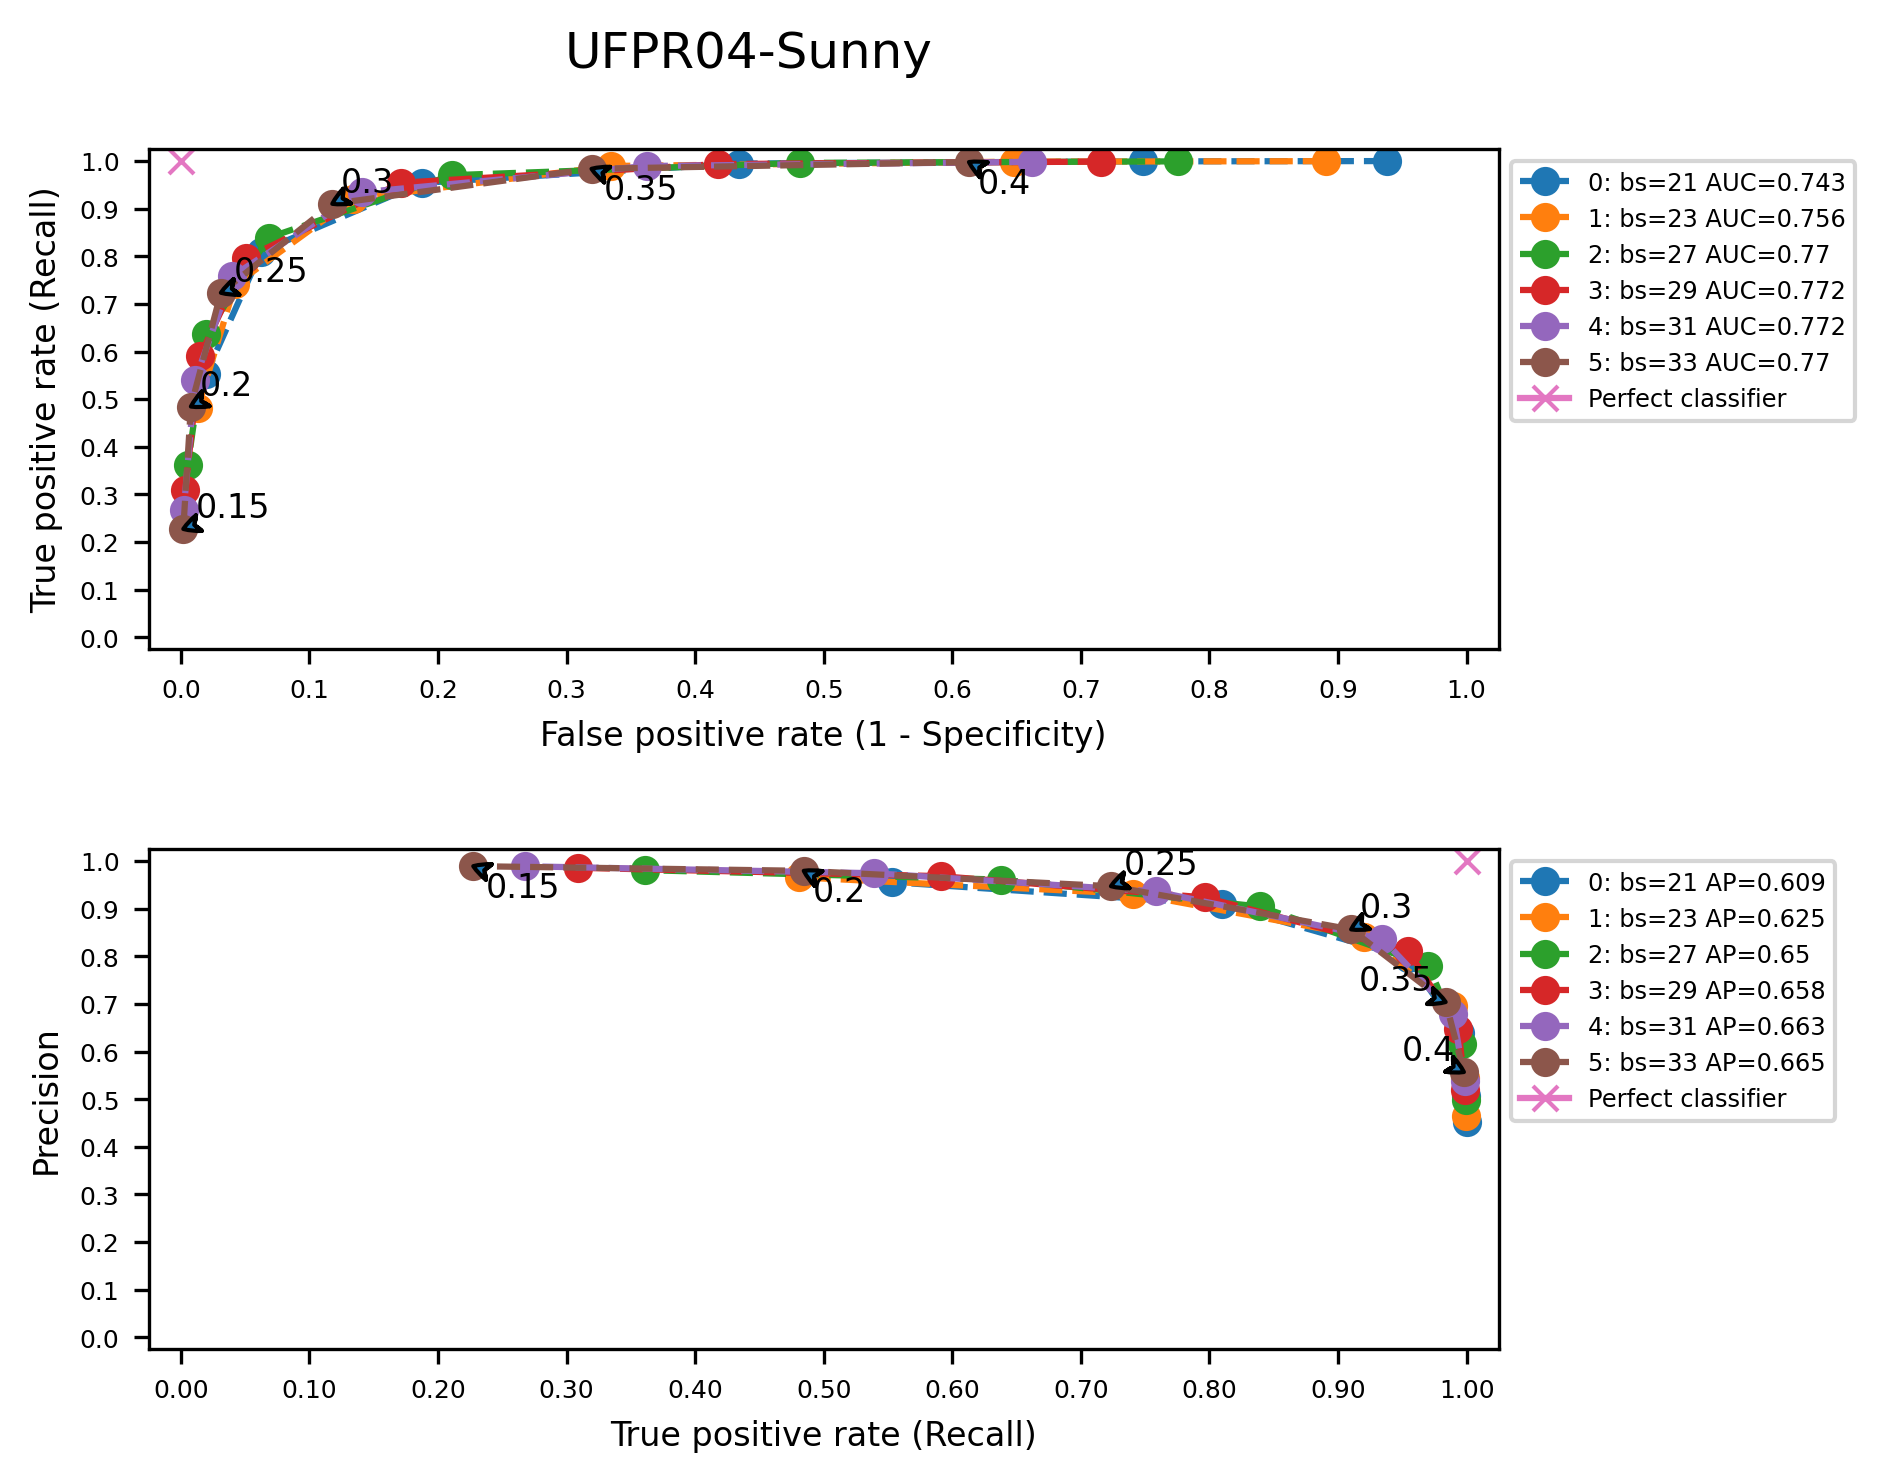

test/bordersDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle


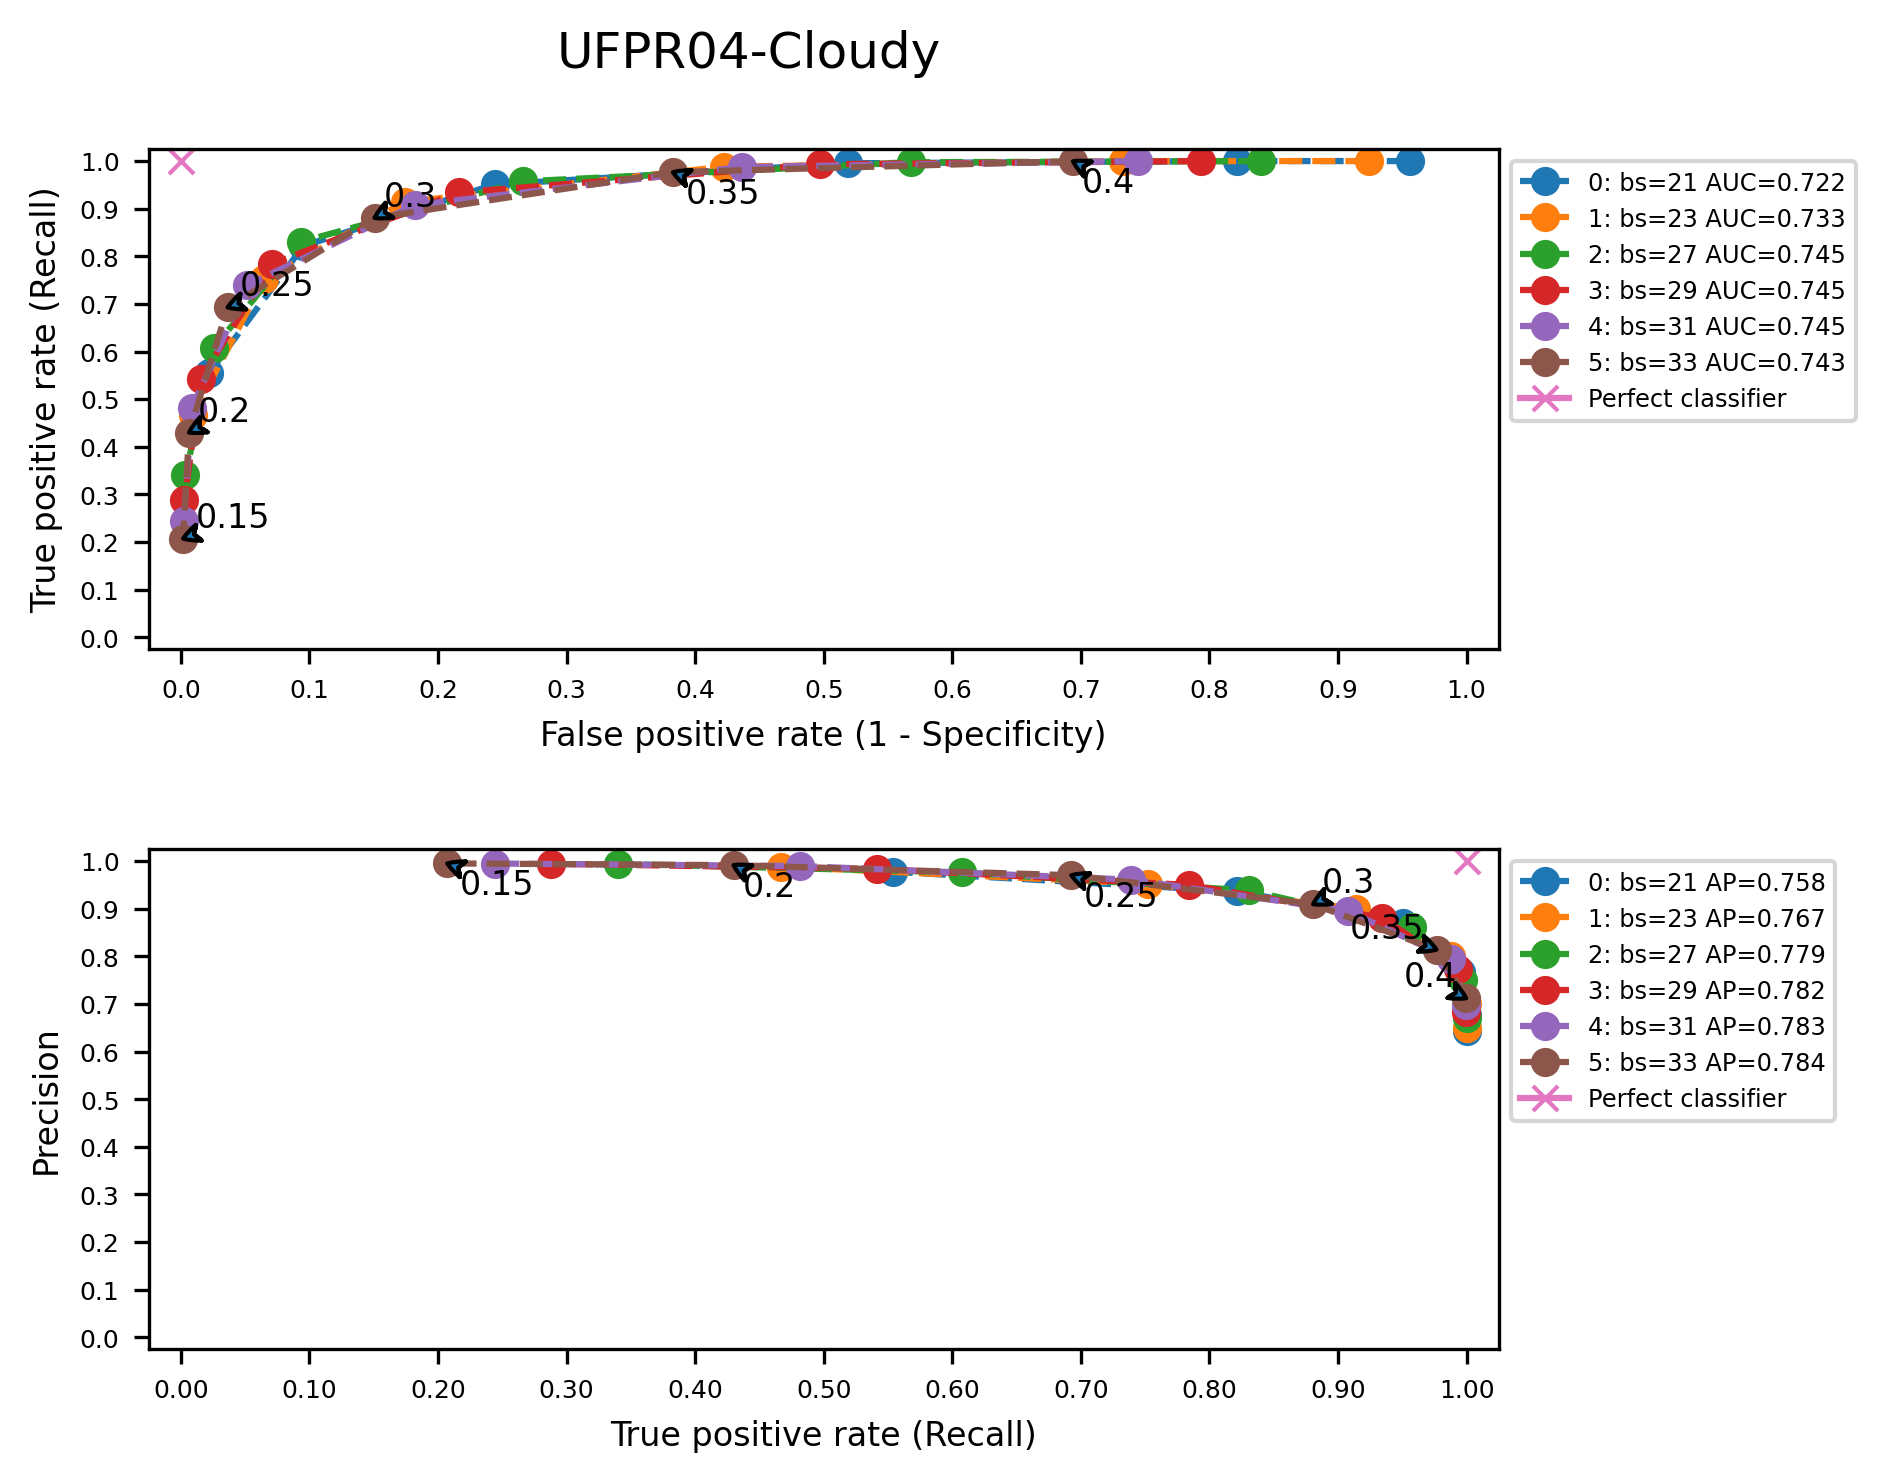

test/bordersDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle


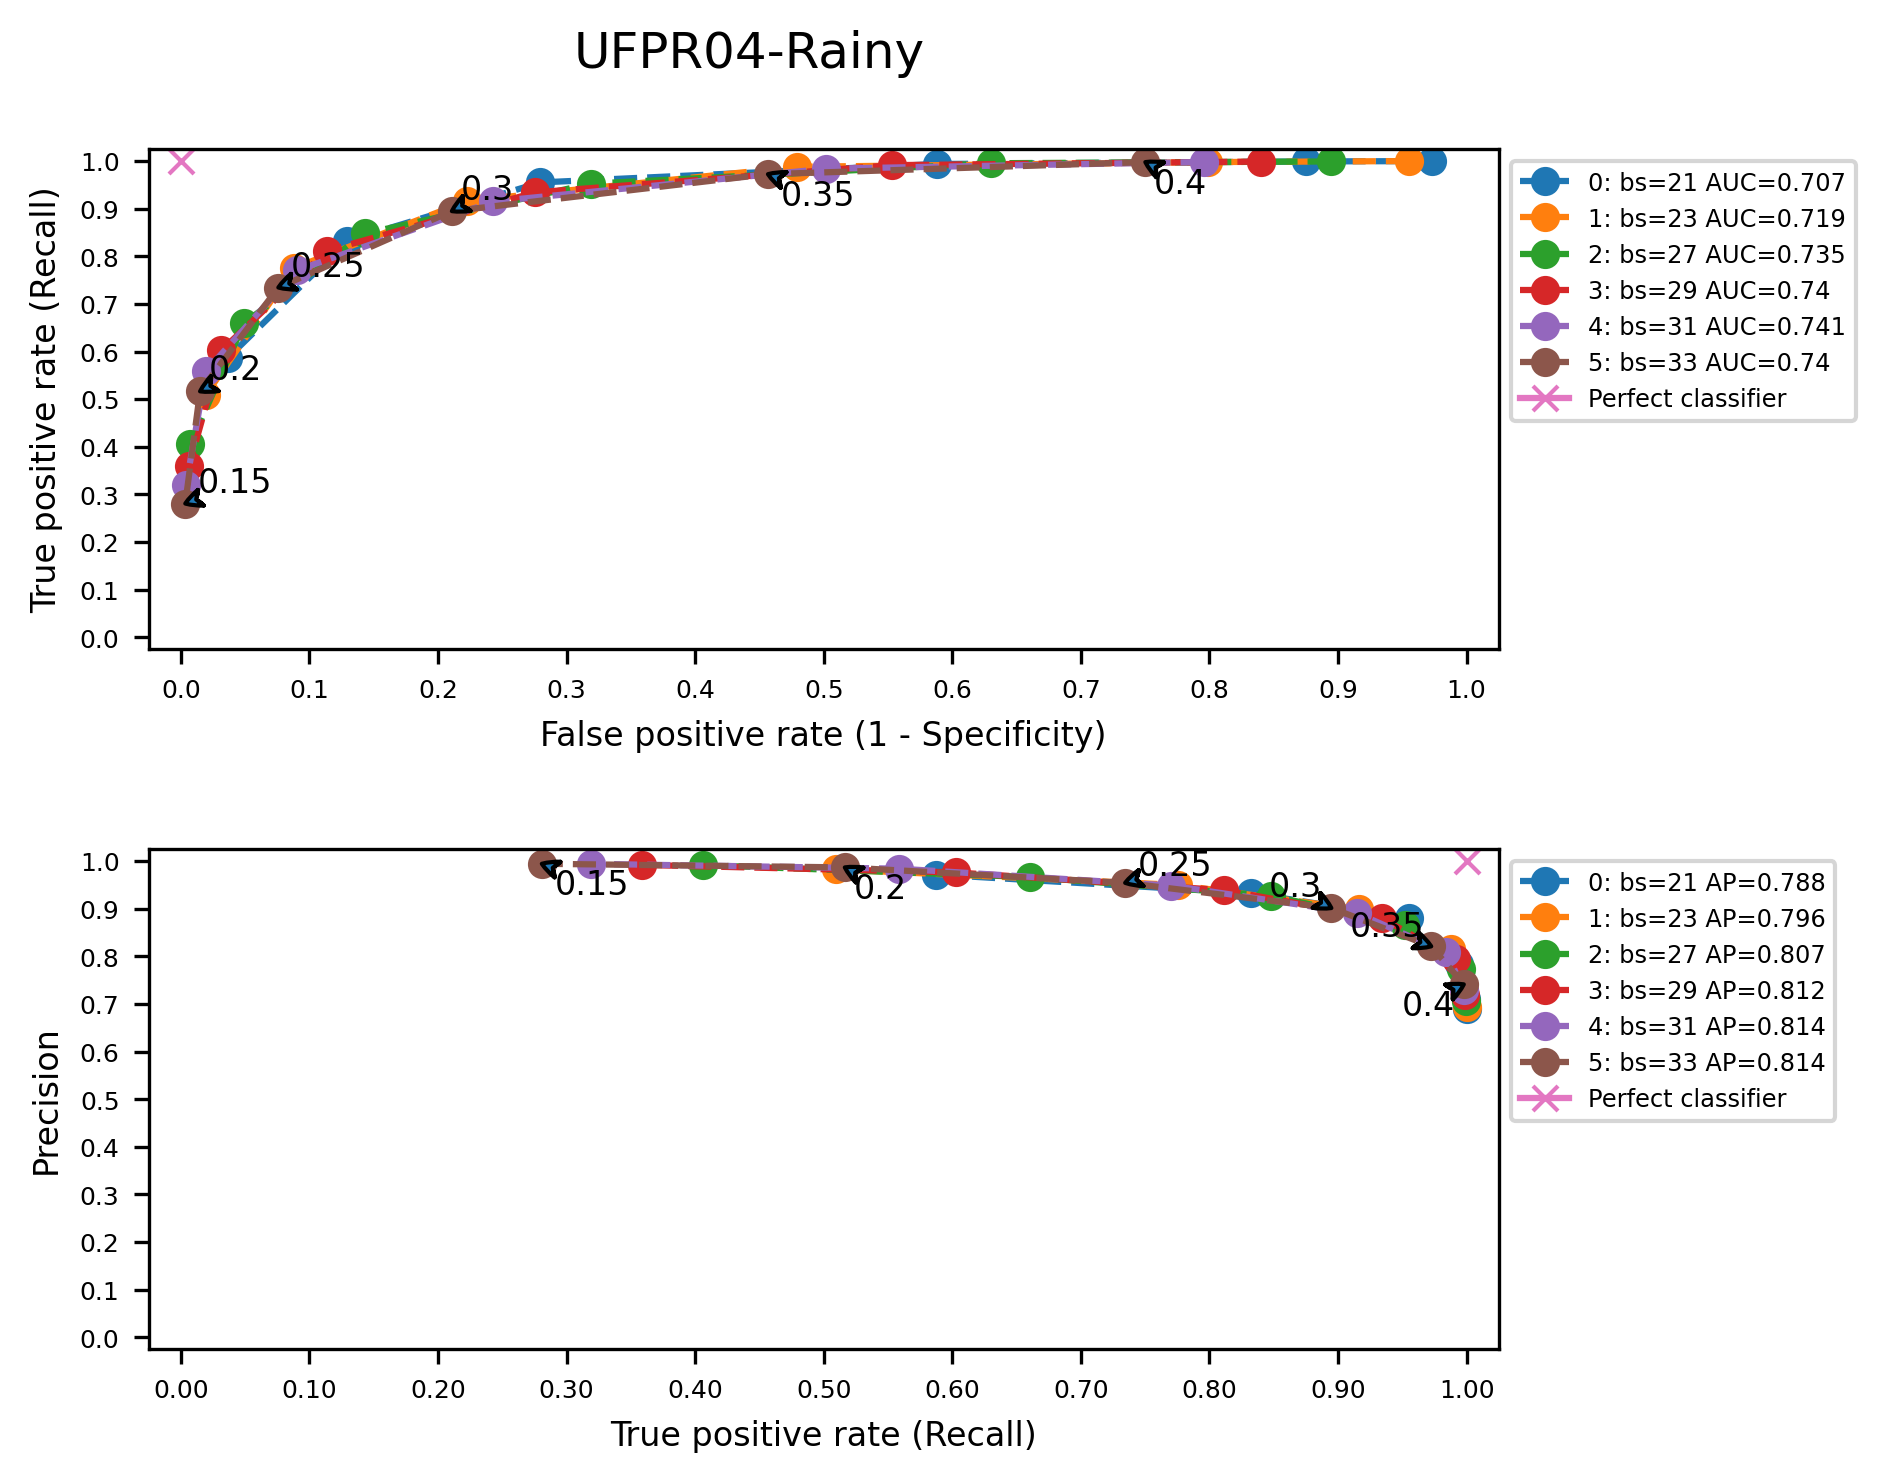

In [2]:
parking_id = 'UFPR04'

vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
at_blockSize_list = [21,23,27,29,31,33]
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C

calculate_metrics(parking_id, weather_list, at_blockSize_list, vacant_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

In [2]:
weather_dict = dict()
parking_id = 'UFPR04'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
training_test_folder = 'training' if training else 'test'

for weather in weather_list:

    file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"

    with open(file_pickle, 'rb') as f:
        print(file_pickle)
        metrics_dict_vt = pickle.load(f)
        
        weather_dict[weather] = transpose_dict(metrics_dict_vt)
        
metrics_UFPR04 = PerformanceMetricsProviderSklearn.choose_parameters(weather_dict)

# establecer temporalmente las opciones de visualización para mostrar todas las filas

pd.set_option('display.max_rows', None)

display(metrics_UFPR04.sort_values(by=["block_size"]))

test/bordersDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle

Best parameters for weather: Sunny
block_size: 33			Selected from max AUC=0.8167510406168637
vacant_threshold: 0.3		Selected from max f1=0.8825294033617447

Best parameters for weather: Cloudy
block_size: 33			Selected from max AUC=0.7857587126042425
vacant_threshold: 0.3		Selected from max f1=0.8947433366238895

Best parameters for weather: Rainy
block_size: 33			Selected from max AUC=0.7632856428738626
vacant_threshold: 0.3		Selected from max f1=0.898084906923798

Best GLOBAL parameters
block_size: 33			Selected from max AUC=0.8167510406168637 and weather Sunny
vacant_threshold: 0.3		Selected from max f1=0.8825294033617447


,weather_condition,block_size,vacant_threshold,AUC,AP,precision,specificity,recall,F1,accuracy
0,Sunny,21,0.40,0.743398,0.609257,0.451476,0.061851,1.000000,0.622092,0.470620
76,Rainy,21,0.20,0.707174,0.787967,0.932715,0.870764,0.832399,0.879707,0.844570
75,Rainy,21,0.25,0.707174,0.787967,0.880226,0.720276,0.955164,0.916165,0.880649
74,Rainy,21,0.30,0.707174,0.787967,0.784330,0.411832,0.993862,0.876751,0.809220
73,Rainy,21,0.35,0.707174,0.787967,0.710841,0.125215,0.999199,0.830708,0.721939
72,Rainy,21,0.40,0.707174,0.787967,0.688660,0.026996,1.000000,0.815629,0.691327
36,Cloudy,21,0.40,0.722042,0.758402,0.642152,0.044062,1.000000,0.782086,0.647959
37,Cloudy,21,0.35,0.722042,0.758402,0.676137,0.178333,1.000000,0.806780,0.697407
38,Cloudy,21,0.30,0.722042,0.758402,0.766985,0.481250,0.995385,0.866385,0.806046
77,Rainy,21,0.15,0.707174,0.787967,0.971731,0.963240,0.587136,0.731991,0.706450


In [4]:
data = [
    ["PUCPR", "Sunny", 1843, 184300, 471, 47100],
    ["PUCPR", "Cloudy", 1059, 105900, 269, 26900],
    ["PUCPR", "Rainy", 662, 66200, 169, 16900],
    ["UFPR04", "Sunny", 1669, 46732, 429, 12012],
    ["UFPR04", "Cloudy", 1120, 31360, 288, 8064],
    ["UFPR04", "Rainy", 224, 6272, 61, 1708],
    ["UFPR05", "Sunny", 1989, 89505, 511, 22995],
    ["UFPR05", "Cloudy", 1133, 50985, 293, 13185],
    ["UFPR05", "Rainy", 177, 7965, 49, 2205]
]

for row in data:
    total_training = row[3]
    total_testing = row[5]
    percentage_training = round((total_training / (total_training + total_testing)) * 100,1)
    percentage_testing = round((total_testing / (total_training + total_testing)) * 100,1)
    print(f"{row[0]} - {row[1]}: Training ({percentage_training}\%) ({total_training}), Testing ({percentage_testing}\%) ({total_testing})")


PUCPR - Sunny: Training (79.6\%) (184300), Testing (20.4\%) (47100)
PUCPR - Cloudy: Training (79.7\%) (105900), Testing (20.3\%) (26900)
PUCPR - Rainy: Training (79.7\%) (66200), Testing (20.3\%) (16900)
UFPR04 - Sunny: Training (79.6\%) (46732), Testing (20.4\%) (12012)
UFPR04 - Cloudy: Training (79.5\%) (31360), Testing (20.5\%) (8064)
UFPR04 - Rainy: Training (78.6\%) (6272), Testing (21.4\%) (1708)
UFPR05 - Sunny: Training (79.6\%) (89505), Testing (20.4\%) (22995)
UFPR05 - Cloudy: Training (79.5\%) (50985), Testing (20.5\%) (13185)
UFPR05 - Rainy: Training (78.3\%) (7965), Testing (21.7\%) (2205)


### UFPR04 Testing

UFPR04-Sunny Testing
Using OccupancyDetectorBorders
Processing 429 files with 10 workers


100%|██████████| 429/429 [01:22<00:00,  5.18it/s]

Precision: 0.816
specificity: 0.786
Recall: 0.957
F1 Score: 0.881
Accuracy: 0.871


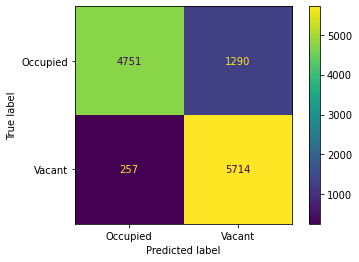

UFPR04-Cloudy Testing
Using OccupancyDetectorBorders
Processing 288 files with 10 workers


100%|██████████| 288/288 [00:59<00:00,  4.86it/s]

Precision: 0.902
specificity: 0.764
Recall: 0.929
F1 Score: 0.915
Accuracy: 0.879


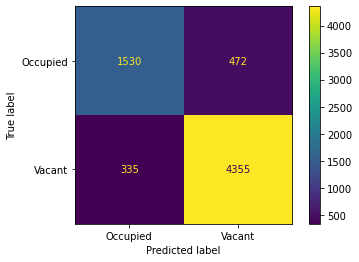

UFPR04-Rainy Testing
Using OccupancyDetectorBorders
Processing 61 files with 10 workers


100%|██████████| 61/61 [00:14<00:00,  4.25it/s]

Precision: 0.844
specificity: 0.777
Recall: 0.915
F1 Score: 0.878
Accuracy: 0.855


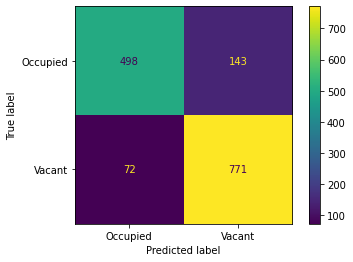

In [4]:
parking_id = 'UFPR04'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 33
detection_params.vacant_threshold = 0.3


weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)

In [ ]:
parking_id = 'UFPR04'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 33
detection_params.vacant_threshold = 0.3
detection_params.show_imshow =True


weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, process_batch=False, training=training)

## UFPR05

### UPFR05 Training

In [ ]:
parking_id = 'UFPR05'

vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
at_blockSize_list = [21,23,27,29,31,33]
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
params.median_k = -1


calculate_metrics(parking_id, weather_list, at_blockSize_list, vacant_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

In [3]:
weather_dict = dict()
parking_id = 'UFPR05'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
training_test_folder = 'training' if training else 'test'

for weather in weather_list:

    file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"

    with open(file_pickle, 'rb') as f:
        print(file_pickle)
        metrics_dict_vt = pickle.load(f)
        
        weather_dict[weather] = transpose_dict(metrics_dict_vt)
        
metrics_UFPR05 =PerformanceMetricsProviderSklearn.choose_parameters(weather_dict)

test/bordersDetector/metrics_dict_vt_UFPR05_Sunny_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR05_Cloudy_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR05_Rainy_training.pickle

Best parameters for weather: Sunny
block_size: 33			Selected from max AUC=0.7953584833187006
vacant_threshold: 0.3		Selected from max f1=0.8568942203419331

Best parameters for weather: Cloudy
block_size: 33			Selected from max AUC=0.7962176134715285
vacant_threshold: 0.3		Selected from max f1=0.8604868453405459

Best parameters for weather: Rainy
block_size: 33			Selected from max AUC=0.8010708428850952
vacant_threshold: 0.25		Selected from max f1=0.8012791228871632

Best GLOBAL parameters
block_size: 33			Selected from max AUC=0.8010708428850952 and weather Rainy
vacant_threshold: 0.25		Selected from max f1=0.8012791228871632


### UFPR05 Testing

UFPR05-Sunny Testing
Using OccupancyDetectorBorders
Processing 511 files with 10 workers


100%|██████████| 511/511 [01:16<00:00,  6.71it/s]


Precision: 0.788
specificity: 0.833
Recall: 0.912
F1 Score: 0.846
Accuracy: 0.865


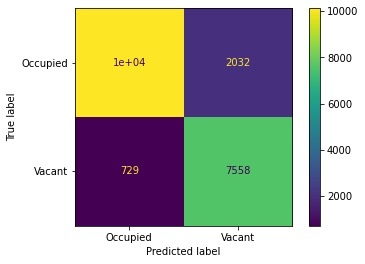

UFPR05-Cloudy Testing
Using OccupancyDetectorBorders
Processing 293 files with 10 workers


100%|██████████| 293/293 [00:46<00:00,  6.33it/s]

Precision: 0.761
specificity: 0.820
Recall: 0.900
F1 Score: 0.825
Accuracy: 0.851


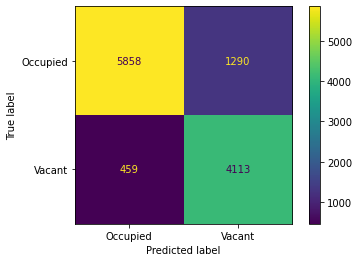

UFPR05-Rainy Testing
Using OccupancyDetectorBorders
Processing 49 files with 10 workers


100%|██████████| 49/49 [00:08<00:00,  5.89it/s]


Precision: 0.690
specificity: 0.789
Recall: 0.940
F1 Score: 0.796
Accuracy: 0.839


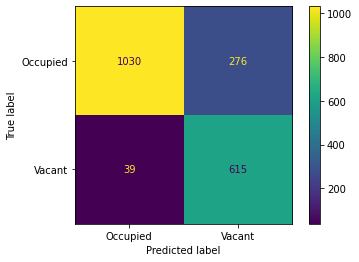

In [6]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 33
detection_params.vacant_threshold = 0.3

weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)

## PUCPR

### PUCPR Training

In [ ]:
parking_id = 'PUCPR'
vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
at_blockSize_list = [21,23,27,29,31,33]
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C

calculate_metrics(parking_id, weather_list, at_blockSize_list, vacant_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

In [4]:
weather_dict = dict()
parking_id = 'PUCPR'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
training_test_folder = 'training' if training else 'test'

for weather in weather_list:

    file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"

    with open(file_pickle, 'rb') as f:
        print(file_pickle)
        metrics_dict_vt = pickle.load(f)
        
        weather_dict[weather] = transpose_dict(metrics_dict_vt)
        
metrics_PUCPR = PerformanceMetricsProviderSklearn.choose_parameters(weather_dict)

# pd.set_option('display.max_rows', None)
# display(metrics_PUCPR)

test/bordersDetector/metrics_dict_vt_PUCPR_Sunny_training.pickle
test/bordersDetector/metrics_dict_vt_PUCPR_Cloudy_training.pickle
test/bordersDetector/metrics_dict_vt_PUCPR_Rainy_training.pickle

Best parameters for weather: Sunny
block_size: 33			Selected from max AUC=0.8596556414807852
vacant_threshold: 0.3		Selected from max f1=0.9063704801206172

Best parameters for weather: Cloudy
block_size: 31			Selected from max AUC=0.8874777725741219
vacant_threshold: 0.3		Selected from max f1=0.9620877370382169

Best parameters for weather: Rainy
block_size: 33			Selected from max AUC=0.8670248670528774
vacant_threshold: 0.3		Selected from max f1=0.8771366775971535

Best GLOBAL parameters
block_size: 31			Selected from max AUC=0.8874777725741219 and weather Cloudy
vacant_threshold: 0.3		Selected from max f1=0.9620877370382169


### PUCPR Testing

PUCPR-Sunny Testing
Using OccupancyDetectorBorders
Processing 471 files with 10 workers


100%|██████████| 471/471 [01:18<00:00,  5.98it/s]

Precision: 0.812
specificity: 0.808
Recall: 0.983
F1 Score: 0.889
Accuracy: 0.888


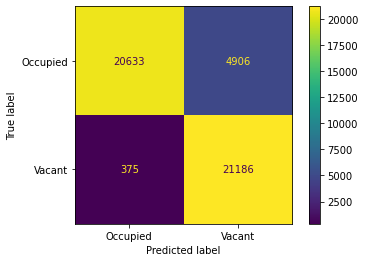

PUCPR-Cloudy Testing
Using OccupancyDetectorBorders
Processing 269 files with 10 workers


100%|██████████| 269/269 [01:00<00:00,  4.47it/s]

Precision: 0.972
specificity: 0.950
Recall: 0.945
F1 Score: 0.958
Accuracy: 0.947


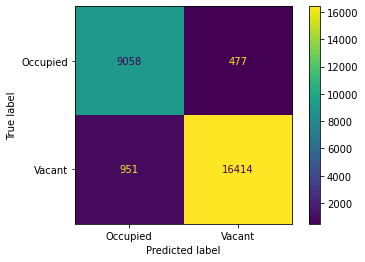

PUCPR-Rainy Testing
Using OccupancyDetectorBorders
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:32<00:00,  5.23it/s]

Precision: 0.913
specificity: 0.960
Recall: 0.843
F1 Score: 0.876
Accuracy: 0.922


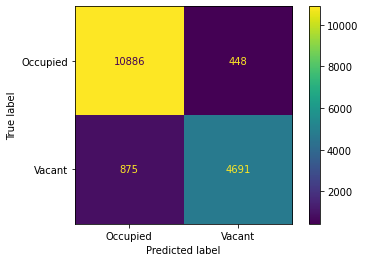

In [5]:
parking_id = 'PUCPR'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 31
detection_params.vacant_threshold = 0.3

weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)

In [ ]:
parking_id = 'UFPR05'
weather = 'Cloudy'
training = False

detection_params = DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 33
detection_params.vacant_threshold = 0.25
detection_params.show_imshow = True
detection_params.median_k = -1
# detection_params.bw_size = 10

training_str = 'Training' if training else 'Testing'
row_name = f'{parking_id}-{weather} {training_str}'

test_parking(parking_id, weather, detection_params, process_batch=False, training=training)

In [ ]:
parking_id = 'UFPR05'

vacant_threshold_list = [0.25]
at_blockSize_list = [33]
weather_list = ['Sunny']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
params.median_k = -1


calculate_metrics(parking_id, weather_list, at_blockSize_list, vacant_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

In [ ]:
parking_id = 'UFPR05'

vacant_threshold_list = [0.25]
at_blockSize_list = [33]
weather_list = ['Sunny']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
params.median_k = 3


calculate_metrics(parking_id, weather_list, at_blockSize_list, vacant_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)